<a href="https://colab.research.google.com/github/Hassanmoin3/Segmentation-and-counting-of-teeths-using-panoramic-dental-X-rays/blob/main/Script/512x512_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing Libraries**

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62

In [ ]:
!pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 34.0 MB/s eta 0:00:00


# **Mounting Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **GPU Check**

In [2]:
!nvidia-smi

Wed Aug  9 01:37:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Appending Path on Drive**

In [3]:
import sys
sys.path.append("/content/drive/MyDrive/dissertation/")

In [4]:
%cd /content/drive/MyDrive/dissertation

/content/drive/MyDrive/dissertation


# **Loading and Preparing Images**

In [5]:
from images_prepare import *
path = "/content/drive/MyDrive/dissertation/Data"
X,X_sizes=pre_images((512,512),path,True)
len(X)

1000

# **Loading and Preparing Masks**

In [ ]:
from masks_prepare import *
Y=pre_masks(resize_shape=(512,512),path='/content/drive/MyDrive/dissertation/Data/Original_Masks1')

In [ ]:
X=np.float32(X/255)
Y=np.float32(Y/255)
print(len(X))
print(len(Y))

# **Splitting Image and Masks**

In [ ]:
from sklearn.model_selection import train_test_split
x, x_test, y, y_test = train_test_split(X, Y , test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=42)


# **Exploratory Data Analysis**

## **Display Random Images**

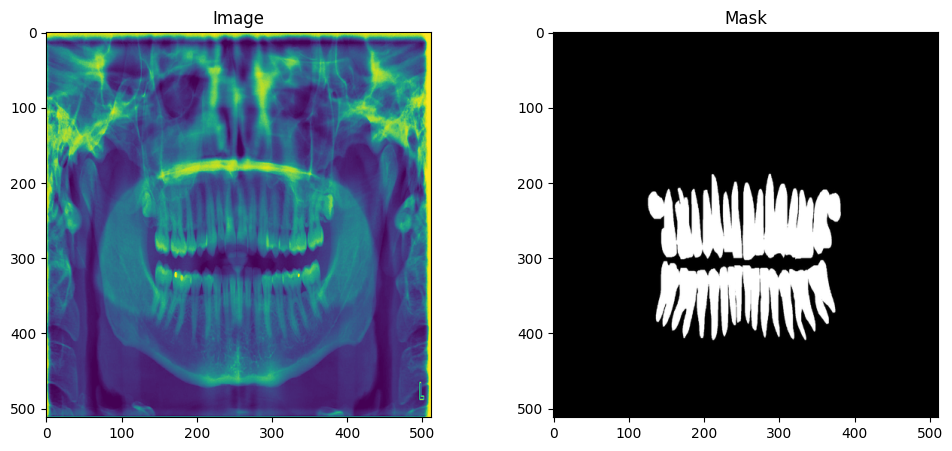

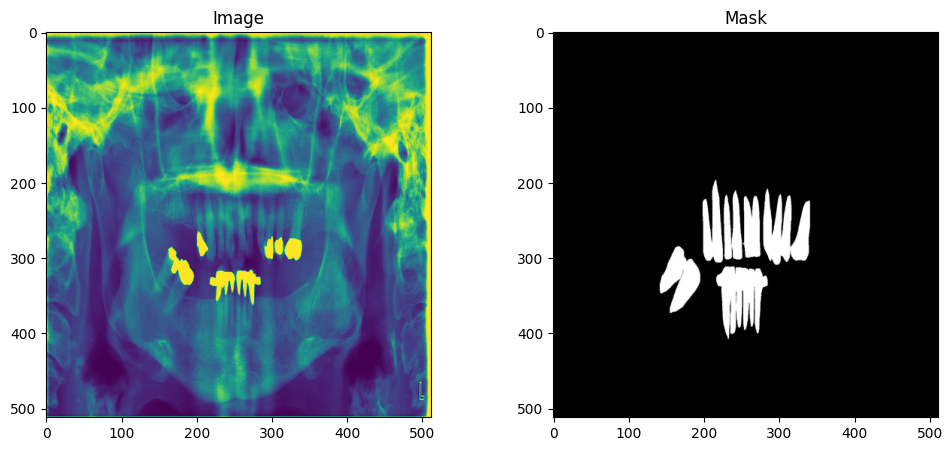

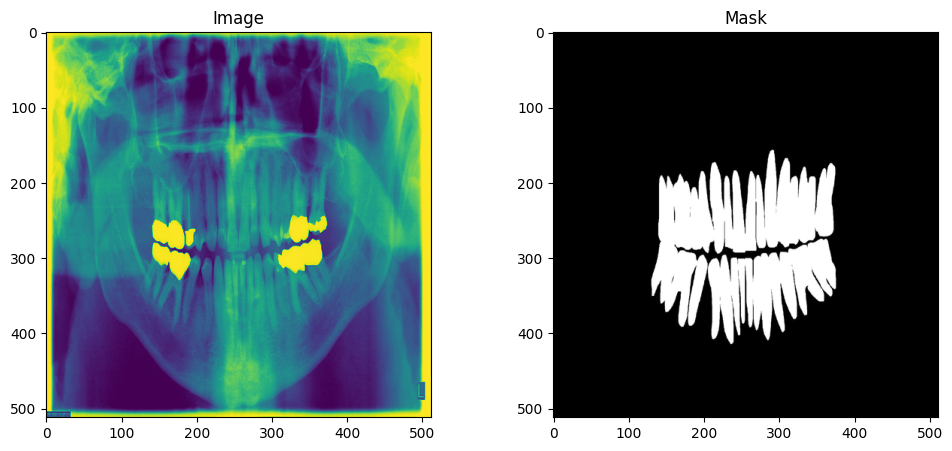

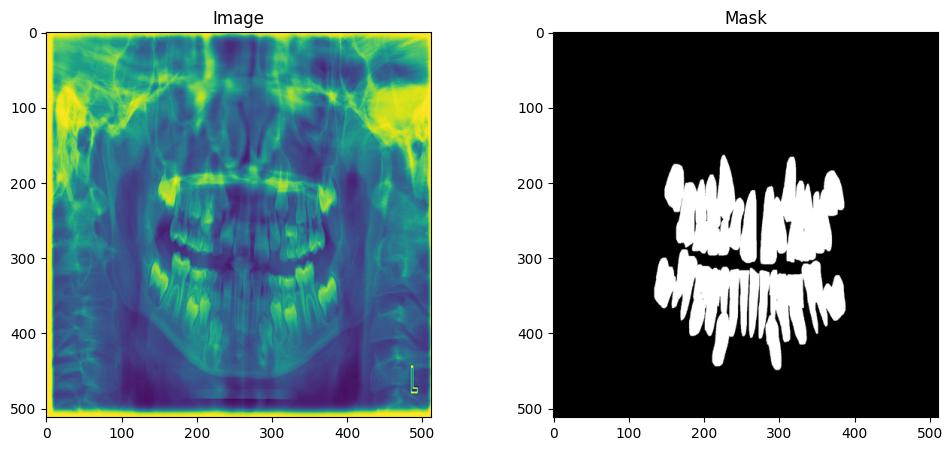

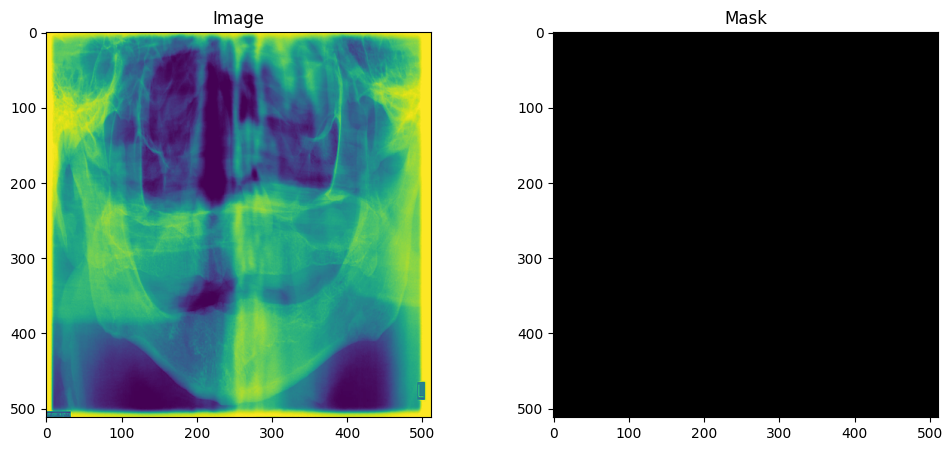

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def display_random_images(x, y, num=5):
    idx = np.random.choice(len(x), size=num, replace=False)

    for i in idx:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(x[i])
        plt.title("Image")

        plt.subplot(1, 2, 2)
        plt.imshow(y[i], cmap='gray')
        plt.title("Mask")

        plt.show()

display_random_images(x_train, y_train)

## **Distribution of Images**

In [20]:
print(f"Training data: {len(x_train)} images")
print(f"Validation data: {len(x_val)} images")
print(f"Test data: {len(x_test)} images")

Training data: 3000 images
Validation data: 200 images
Test data: 200 images


## **Image Statistics**

In [13]:
train_pixel_values = np.array([np.mean(img) for img in x_train])
print(f"Mean pixel value in training images: {np.mean(train_pixel_values)}")
print(f"Std pixel value in training images: {np.std(train_pixel_values)}")

Mean pixel value in training images: 0.47495850920677185
Std pixel value in training images: 0.09159606695175171


## **Check for Missing Data**

In [14]:
print(f"Missing training images: {np.sum(np.isnan(x_train))}")
print(f"Missing training masks: {np.sum(np.isnan(y_train))}")

Missing training images: 0
Missing training masks: 0


## **Histogram of Pixel Values**

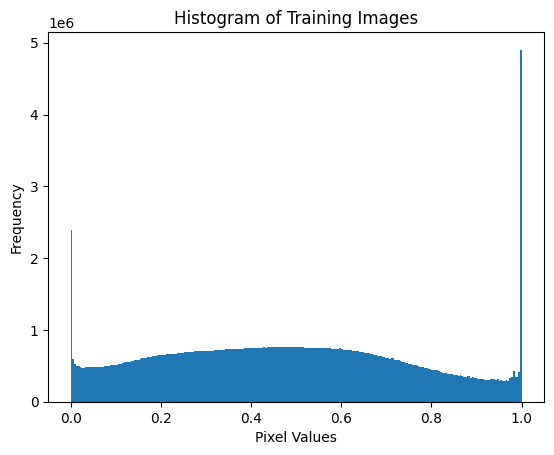

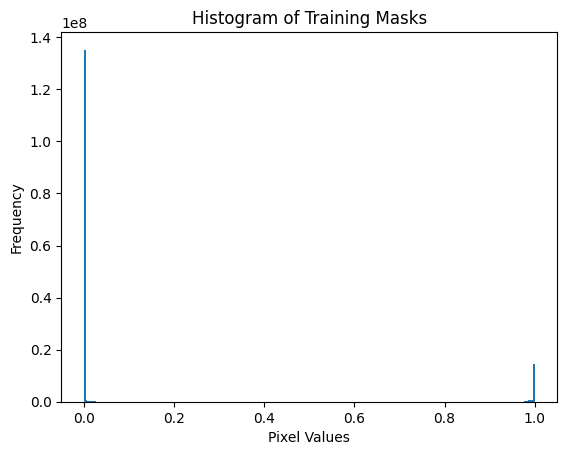

In [15]:
def plot_histogram(images, title):
    plt.hist(images.ravel(), bins=255)
    plt.xlabel('Pixel Values')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

plot_histogram(x_train, 'Histogram of Training Images')
plot_histogram(y_train, 'Histogram of Training Masks')

## **Unique Classes in Masks**

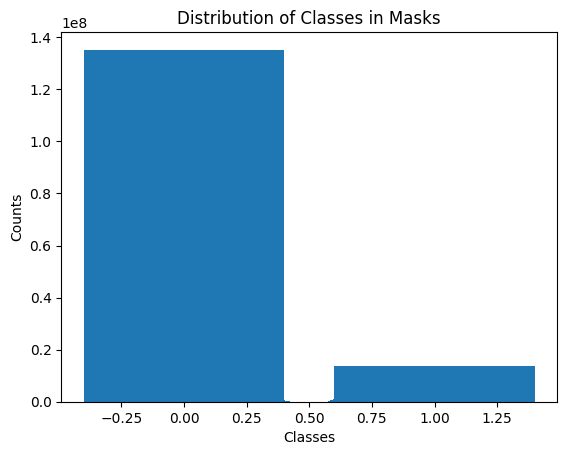

In [16]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribution of Classes in Masks')
plt.show()

# **Applying augmentation to the Data**

In [9]:
import cv2

import albumentations as A

aug = A.Compose([
    A.OneOf([A.RandomCrop(width=512, height=512),

                 A.PadIfNeeded(min_height=512, min_width=512, p=0.5)],p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25,p=0.5),
    A.Compose([A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
                            A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT),
                            A.Resize(512, 512, cv2.INTER_NEAREST), ],p=0.5),
    A.ShiftScaleRotate (shift_limit=0.325, scale_limit=0.15, rotate_limit=15,border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15,p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25,  always_apply=False, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, always_apply=False, p=0.5),
    A.HorizontalFlip(p=0.25),
])

x_train1=np.copy(x_train)
y_train1=np.copy(y_train)
count=0
while(count<4):
  x_aug2=np.copy(x_train1)
  y_aug2=np.copy(y_train1)
  for i in range(len(x_train1)):
    augmented=aug(image=x_train1[i,:,:,:],mask=y_train1[i,:,:,:])
    x_aug2[i,:,:,:]= augmented['image']
    y_aug2[i,:,:,:]= augmented['mask']
  x_train=np.concatenate((x_train,x_aug2))
  y_train=np.concatenate((y_train,y_aug2))
  if count == 9:
    break
  count += 1

In [10]:
#For Relase unneccasery memory
del x_aug2
del X
del Y
del y_aug2
del y_train1
del x_train1
del augmented

In [11]:
print(len(x_train))
print(len(x_val))
print(len(y_train))
print(len(y_val))

3000
200
3000
200


# **Image and Mask check before Training**

In [12]:
import random
import matplotlib.pyplot as plt
random_number=random.randint(0,104)
print(random_number)

10


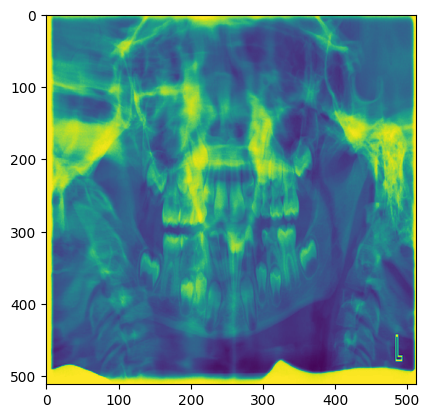

In [13]:
plt.imshow(x_train[random_number,:,:,0])

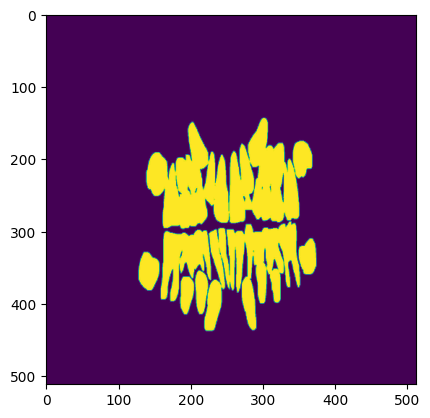

In [14]:
plt.imshow(y_train[random_number,:,:,0])

# **Training**

### **Definition for visualization of results**

In [22]:
import matplotlib.pyplot as plt

def visualize_prediction(test_image, true_mask, predicted_mask):
    plt.figure(figsize=(18, 6))

    # Displaying the test image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title('Test Image')
    plt.axis('off')

    # Displaying the true mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Segmentation Mask')
    plt.axis('off')

    # Displaying the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Segmentation Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def detailed_visualization(test_image, true_mask, predicted_mask):
    plt.figure(figsize=(20, 10))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title('Test Image')
    plt.axis('off')

    # True Mask
    plt.subplot(2, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Segmentation Mask')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(2, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Segmentation Mask')
    plt.axis('off')

    # Overlay of Predicted on Image
    overlay = np.stack([test_image]*3, axis=-1)
    where_mask = np.where(predicted_mask > 0.5)
    overlay[where_mask[0], where_mask[1], :] = [255, 0, 0]
    plt.subplot(2, 3, 4)
    plt.imshow(overlay)
    plt.title('Overlay of Predicted on Image')
    plt.axis('off')

    # Difference between Predicted and True
    difference = np.abs(predicted_mask - true_mask)
    plt.subplot(2, 3, 5)
    plt.imshow(difference, cmap='jet')  # Using a different colormap to highlight differences
    plt.title('Difference between True and Predicted')
    plt.axis('off')

    # Histogram of Predicted Values
    plt.subplot(2, 3, 6)
    plt.hist(predicted_mask.ravel(), bins=50)
    plt.title('Histogram of Predicted Values')

    plt.tight_layout()
    plt.show()

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def advanced_visualization(test_image, true_mask, predicted_mask, threshold=0.5):
    # Binary conversion of predicted_mask
    binary_predicted_mask = (predicted_mask > threshold).astype(np.uint8)

    # Normalize test_image to [0, 1] if it's float
    if test_image.dtype == np.float32 or test_image.dtype == np.float64:
        test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())

    # Errors
    false_positives = np.where((binary_predicted_mask == 1) & (true_mask == 0))
    false_negatives = np.where((binary_predicted_mask == 0) & (true_mask == 1))

    plt.figure(figsize=(20, 10))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title('Test Image')
    plt.axis('off')

    # True vs Predicted Masks
    overlay = np.stack([test_image]*3, axis=-1)
    overlay[false_positives[0], false_positives[1], :] = [1, 0, 0]
    overlay[false_negatives[0], false_negatives[1], :] = [0, 0, 1]
    plt.subplot(2, 3, 2)
    plt.imshow(overlay)
    plt.title('Errors Highlighted (FP=Red, FN=Blue)')
    plt.axis('off')

    # Zoomed Region
    # (Modify these to focus on a specific region of interest)
    zoom_region = (slice(100, 200), slice(100, 200))
    plt.subplot(2, 3, 3)
    plt.imshow(test_image[zoom_region], cmap='gray')
    plt.title('Zoomed Region of Test Image')
    plt.axis('off')

    # Confusion Matrix
    cm = confusion_matrix(true_mask.astype(np.uint8).flatten(), binary_predicted_mask.flatten())
    plt.subplot(2, 3, 4)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

### **UNET Model**

In [ ]:
from model import *
model=UNET(input_shape=(512,512,1),last_activation='sigmoid')
model.summary()
model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(x_train,y_train,batch_size=4,epochs=50,verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 32  0           ['conv2d[0][0]']                 
                                )                                                             

### **Save Model**

In [ ]:
import tensorflow as tf
tf.keras.models.save_model(model, '/content/drive/MyDrive/dissertation/models/dental_xray_seg_new_data_1000_imges_512x512.h5')

### **Load the model if model is already on Drive**

In [32]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/dissertation/models/dental_xray_seg_new_data_1000_imges_512x512.h5')

### **UNET Model Prediction**

In [33]:
predict_img_unet=model.predict(x_test)
predict=predict_img_unet[1,:,:,0]

7/7 [==============================] - 37s 2s/step


### **F1-SCORE UNET Model**

In [34]:
from sklearn.metrics import f1_score
import numpy as np
predict_img1_unet=(predict_img_unet>0.25)*1
y_test1=(y_test>0.25)*1
f1_score(predict_img1_unet.flatten(), y_test1.flatten(), average='micro')

0.9768750953674317

### **Dice score**

In [27]:
dice_score = (2 * np.sum(predict_img1_unet * y_test1)) / (np.sum(predict_img1_unet) + np.sum(y_test1))
print("Dice Score:", dice_score)

Dice Score: 0.9119148985326815


### **Precision, Recell, Jaccard Score, IoU**

In [47]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, jaccard_score

y_test_flat = y_test1.flatten()
predict_flat = predict_img1_unet.flatten()

threshold = 0.5
predict_binary = np.where(predict_flat > threshold, 1, 0)

precision = precision_score(y_test_flat, predict_binary)
recall = recall_score(y_test_flat, predict_binary)
jaccard_coefficient = jaccard_score(y_test_flat, predict_binary)

intersection = np.sum(y_test_flat & predict_binary)
union = np.sum(y_test_flat | predict_binary)
iou = intersection / union

print("Precision:", precision)
print("Recall:", recall)
print("Jaccard Coefficient (IoU):", jaccard_coefficient)
print("IoU:", iou)

Precision: 0.8653424306022545
Recall: 0.963785397107187
Jaccard Coefficient (IoU): 0.8380914098754716
IoU: 0.8380914098754716


### **Visualizing the Results of UNET Model**

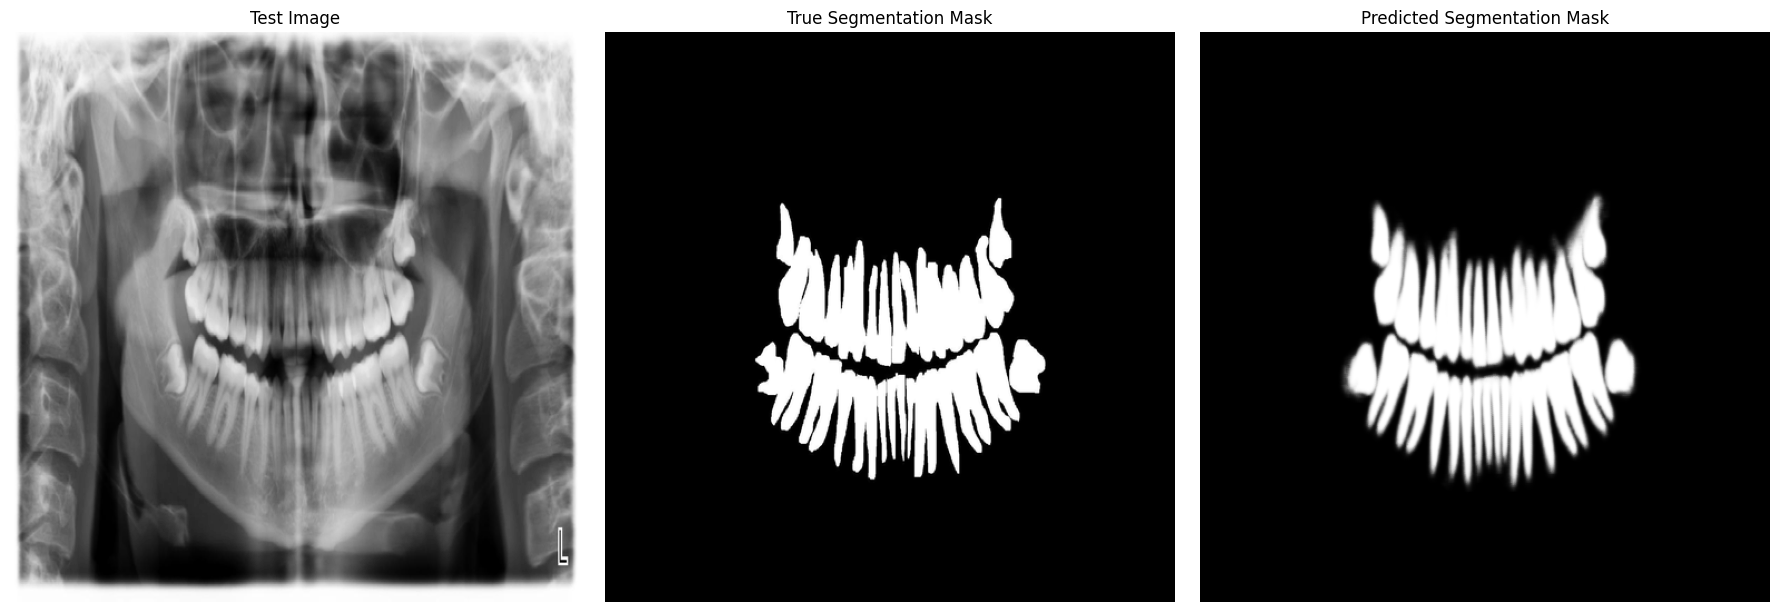

In [32]:
visualize_prediction(x_test[1,:,:,0], y_test[1,:,:,0], predict)

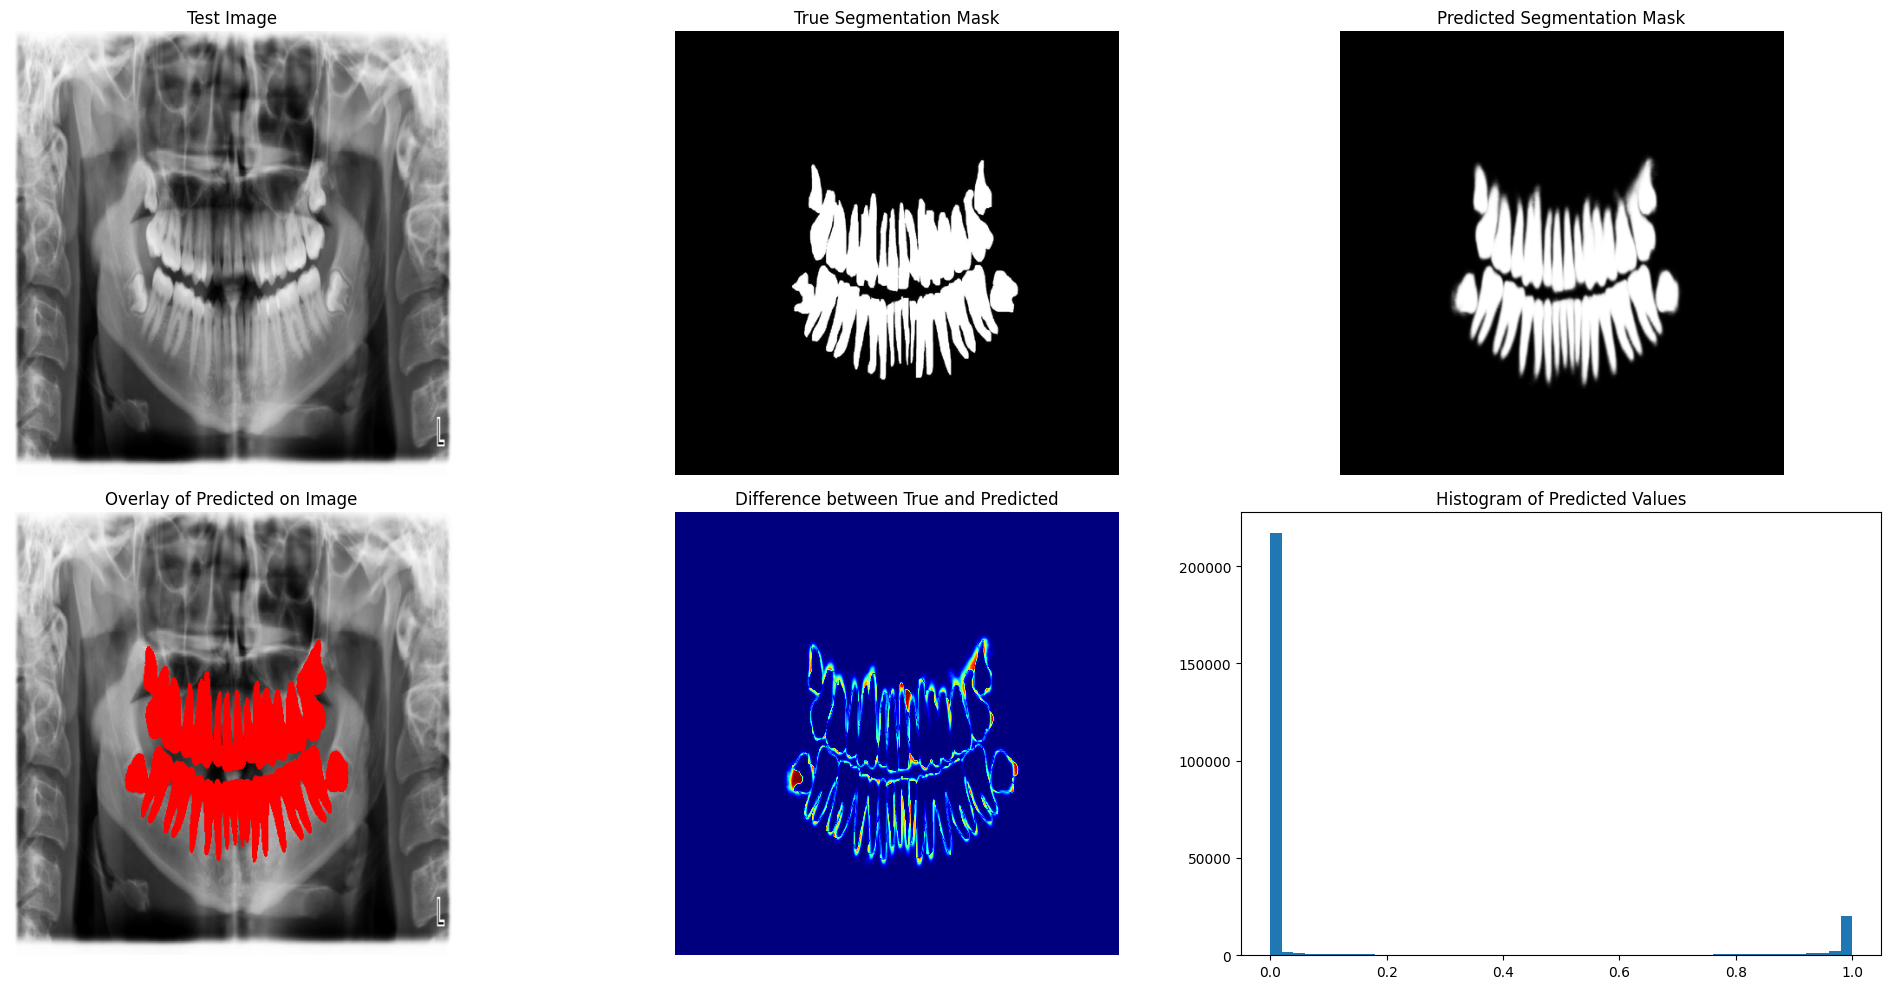

In [33]:
detailed_visualization(x_test[1,:,:,0], y_test[1,:,:,0], predict)

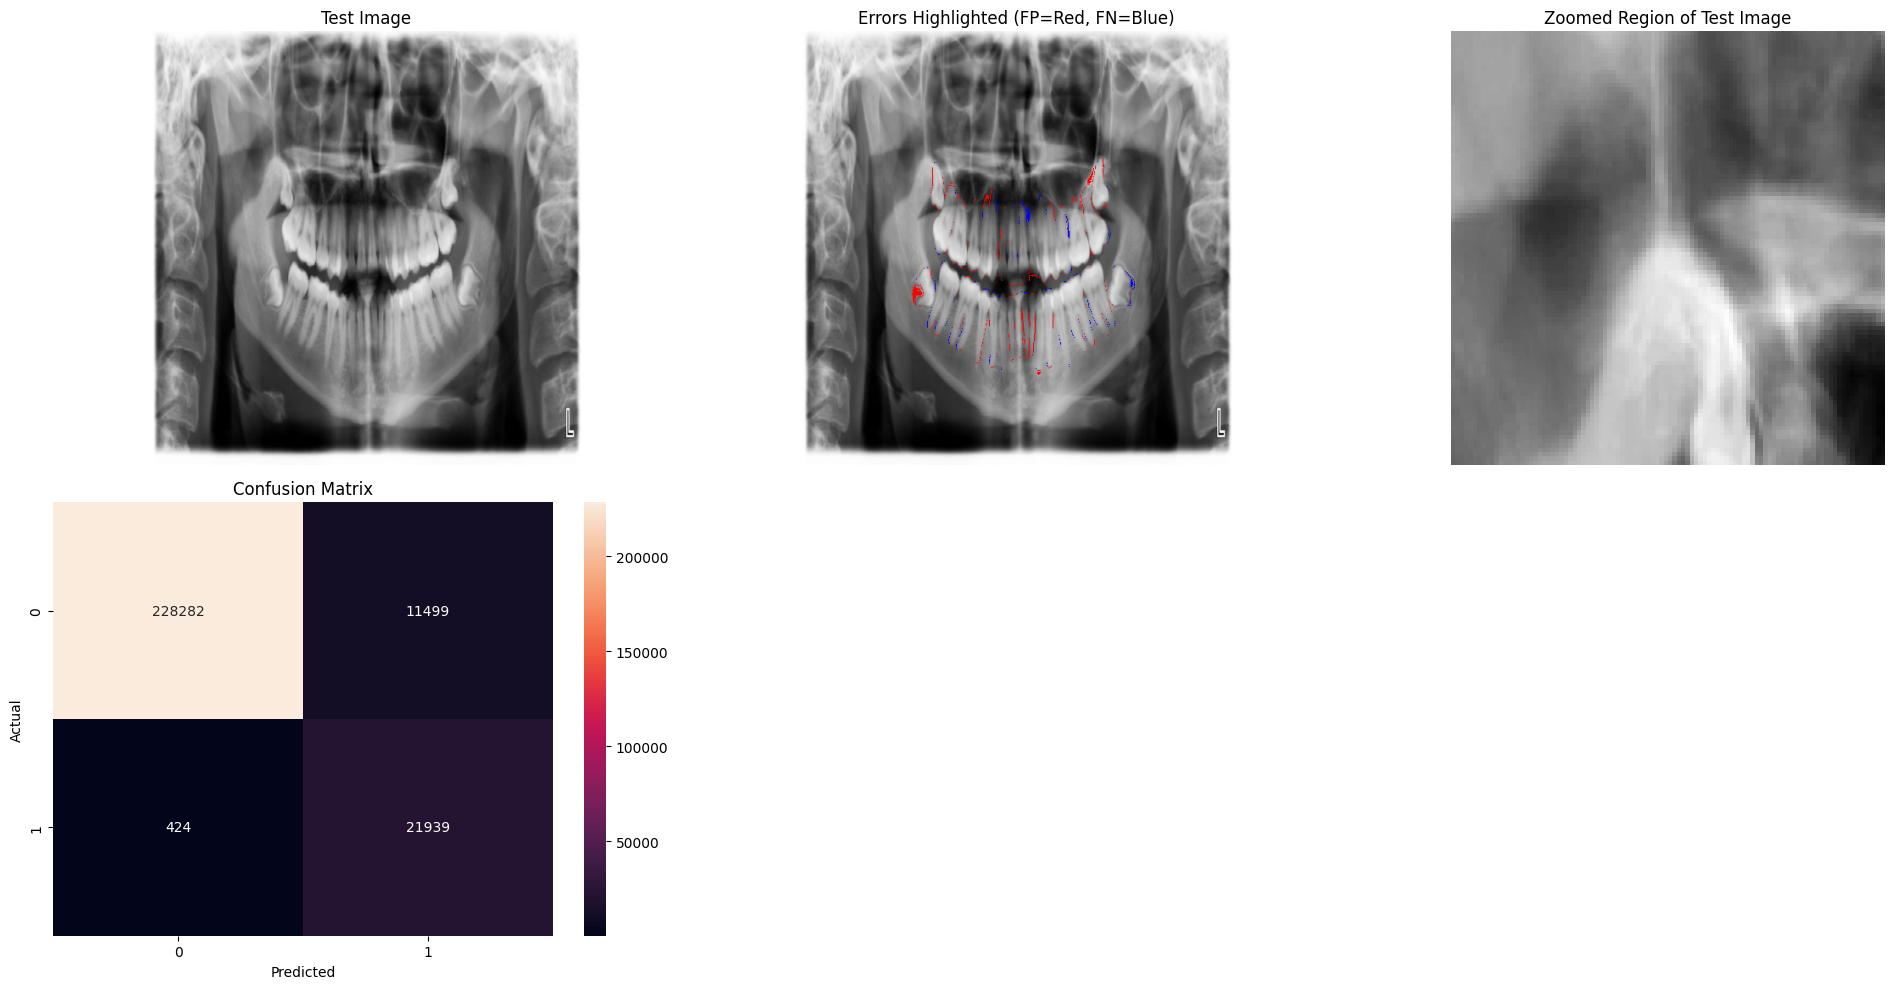

In [34]:
advanced_visualization(x_test[1,:,:,0], y_test[1,:,:,0], predict)

### **UNET++ Model**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(input_tensor)
    x = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(x)
    return x

def build_unetplusplus(input_shape=(512, 512, 1), num_filters=64, dropout_rate=0.5):
    inputs = Input(input_shape)

    # Contracting path
    c1 = conv_block(inputs, num_filters)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, num_filters*2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, num_filters*4)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, num_filters*8)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, num_filters*16)
    c5 = Dropout(dropout_rate)(c5)

    # Expanding path
    u6 = Conv2DTranspose(num_filters*8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout_rate)(u6)
    c6 = conv_block(u6, num_filters*8)

    u7 = Conv2DTranspose(num_filters*4, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout_rate)(u7)
    c7 = conv_block(u7, num_filters*4)

    u8 = Conv2DTranspose(num_filters*2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout_rate)(u8)
    c8 = conv_block(u8, num_filters*2)

    u9 = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout_rate)(u9)
    c9 = conv_block(u9, num_filters)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_unetplusplus()

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

print(x_train.shape)
print(y_train.shape)

x_train = x_train / 255.0

y_train = (y_train > 0).astype(np.float32)

print(x_train.shape)
print(y_train.shape)

model.fit(x_train, y_train, batch_size=4, epochs=10, validation_split=0.2)

(3000, 512, 512, 1)
(3000, 512, 512, 1)
(3000, 512, 512, 1)
(3000, 512, 512, 1)
Epoch 1/10
600/600 [==============================] - 764s 1s/step - loss: 0.3673 - accuracy: 0.8648 - val_loss: 0.3135 - val_accuracy: 0.8684
Epoch 2/10
600/600 [==============================] - 714s 1s/step - loss: 0.2915 - accuracy: 0.8656 - val_loss: 0.2286 - val_accuracy: 0.8684
Epoch 3/10
600/600 [==============================] - 711s 1s/step - loss: 0.1927 - accuracy: 0.9179 - val_loss: 0.1510 - val_accuracy: 0.9384
Epoch 4/10
600/600 [==============================] - 711s 1s/step - loss: 0.1431 - accuracy: 0.9417 - val_loss: 0.1293 - val_accuracy: 0.9469
Epoch 5/10
600/600 [==============================] - 710s 1s/step - loss: 0.1156 - accuracy: 0.9526 - val_loss: 0.1176 - val_accuracy: 0.9516
Epoch 6/10
600/600 [==============================] - 711s 1s/step - loss: 0.1009 - accuracy: 0.9588 - val_loss: 0.0945 - val_accuracy: 0.9618
Epoch 7/10
600/600 [==============================] - 712s 1s/

### **Save Model**

In [ ]:
import tensorflow as tf
tf.keras.models.save_model(model,'/content/drive/MyDrive/dissertation/models/unetplusplus_512x512.h5')

### **Load the model if already on Drive**

In [15]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/dissertation/models/unetplusplus_512x512.h5')

### **UNET++ Model Prediction**

In [16]:
predict_img_unetplus=model.predict(x_test)
predict=predict_img_unetplus[1,:,:,0]

7/7 [==============================] - 78s 4s/step


### **Accuracy**

In [17]:
def calculate_accuracy(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(np.uint8)
    accuracy = np.mean(y_true == y_pred_binary)
    return accuracy
accuracy = calculate_accuracy(y_test, predict_img_unetplus)
print("Accuracy:", accuracy)


Accuracy: 0.820891284942627


### **F1-Score**

In [18]:
from sklearn.metrics import f1_score
import numpy as np
predict_img1_unet=(predict_img_unetplus>0.25)*1
y_test1=(y_test>0.25)*1

f1_score(predict_img1_unet.flatten(), y_test1.flatten(), average='micro')

0.8341637992858887

### **Dice Score**

In [16]:
dice_score = (2 * np.sum(predict_img1_unet * y_test1)) / (np.sum(predict_img1_unet) + np.sum(y_test1))
print("Dice Score:", dice_score)

Dice Score: 0.25831652062765653


### **Precison, Recall, Jaccard Score, IoU**

In [17]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, jaccard_score

y_test_flat = y_test1.flatten()
predict_flat = predict_img1_unet.flatten()

threshold = 0.5
predict_binary = np.where(predict_flat > threshold, 1, 0)

precision = precision_score(y_test_flat, predict_binary)
recall = recall_score(y_test_flat, predict_binary)
jaccard_coefficient = jaccard_score(y_test_flat, predict_binary)

intersection = np.sum(y_test_flat & predict_binary)
union = np.sum(y_test_flat | predict_binary)
iou = intersection / union

print("Precision:", precision)
print("Recall:", recall)
print("Jaccard Coefficient (IoU):", jaccard_coefficient)
print("IoU:", iou)

Precision: 0.29055025727645045
Recall: 0.23252061111960015
Jaccard Coefficient (IoU): 0.14831427391201238
IoU: 0.14831427391201238


### **Visualizing the Results of UNET++ Model**

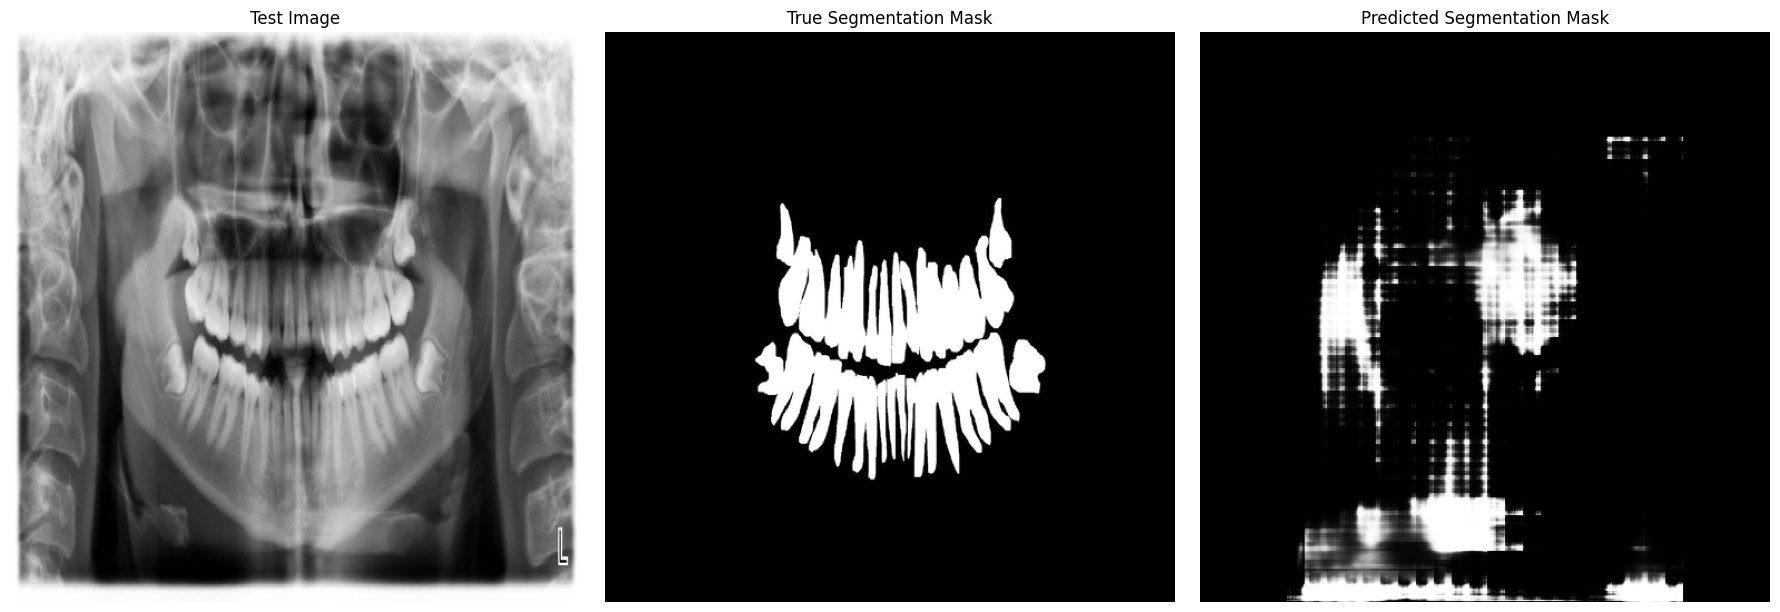

In [25]:
visualize_prediction(x_test[1,:,:,0], y_test[1,:,:,0], predict)

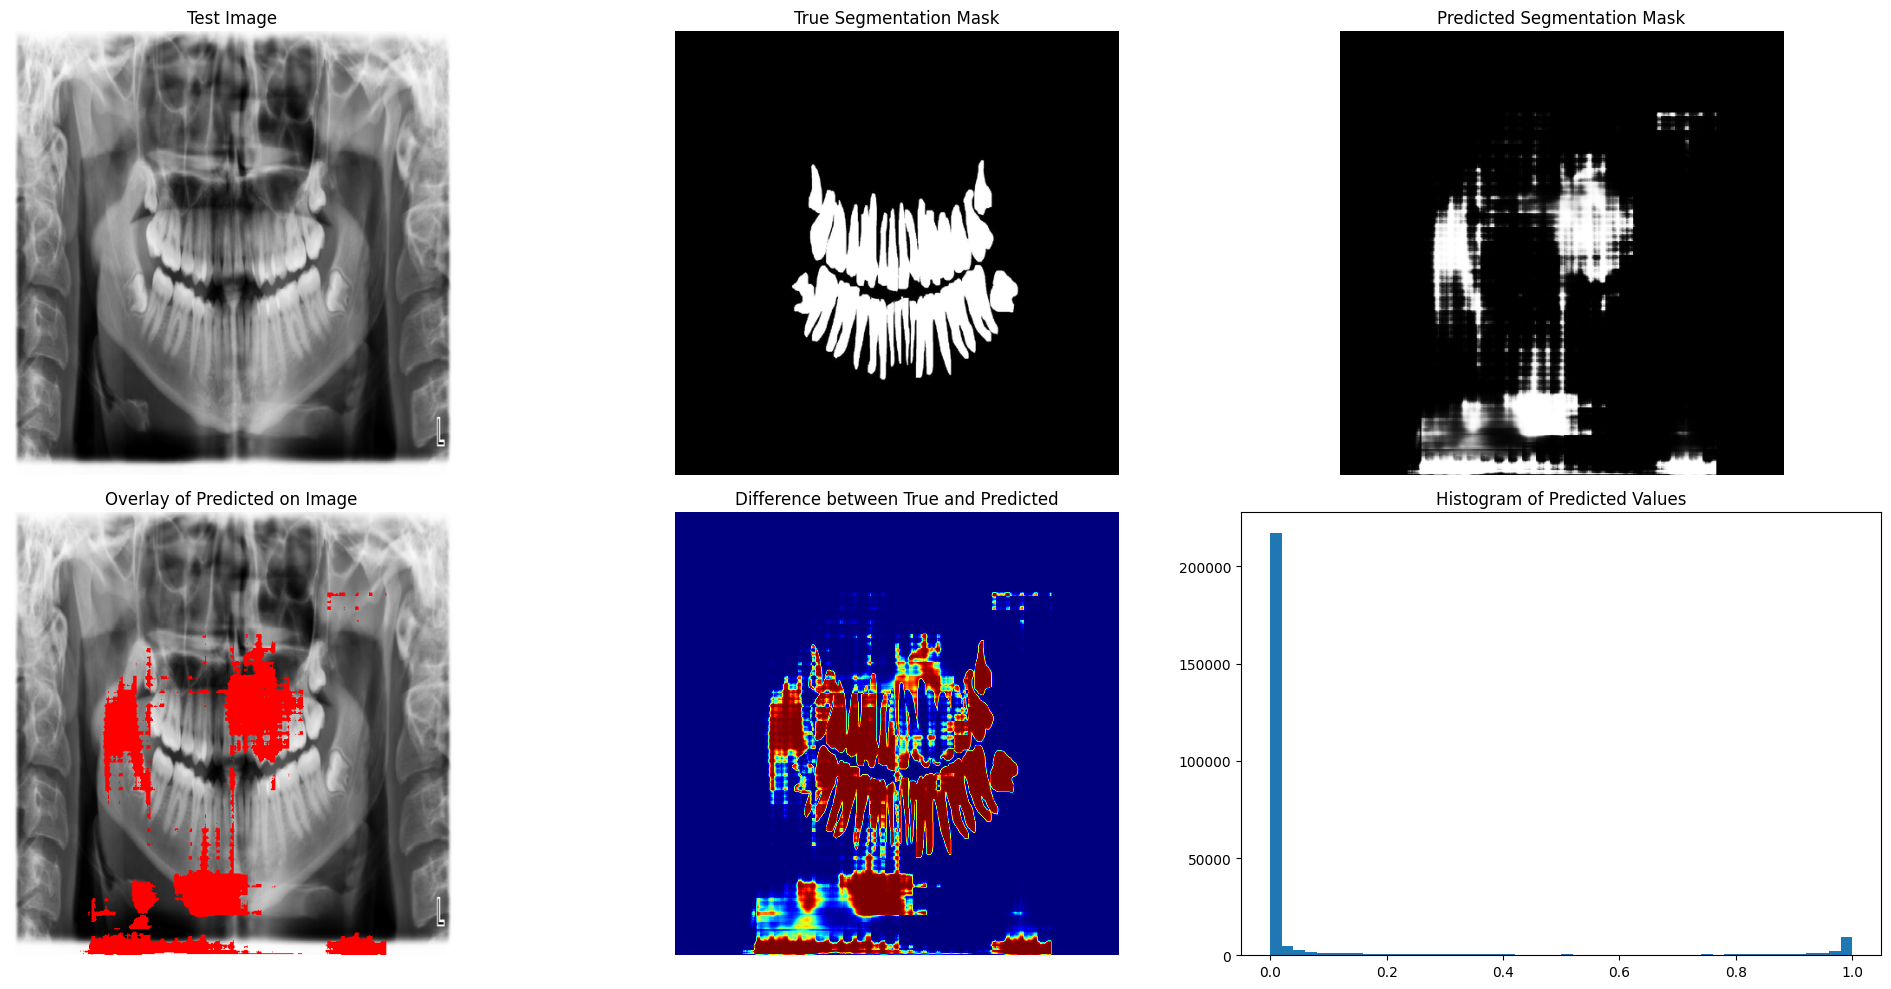

In [26]:
detailed_visualization(x_test[1,:,:,0], y_test[1,:,:,0], predict)

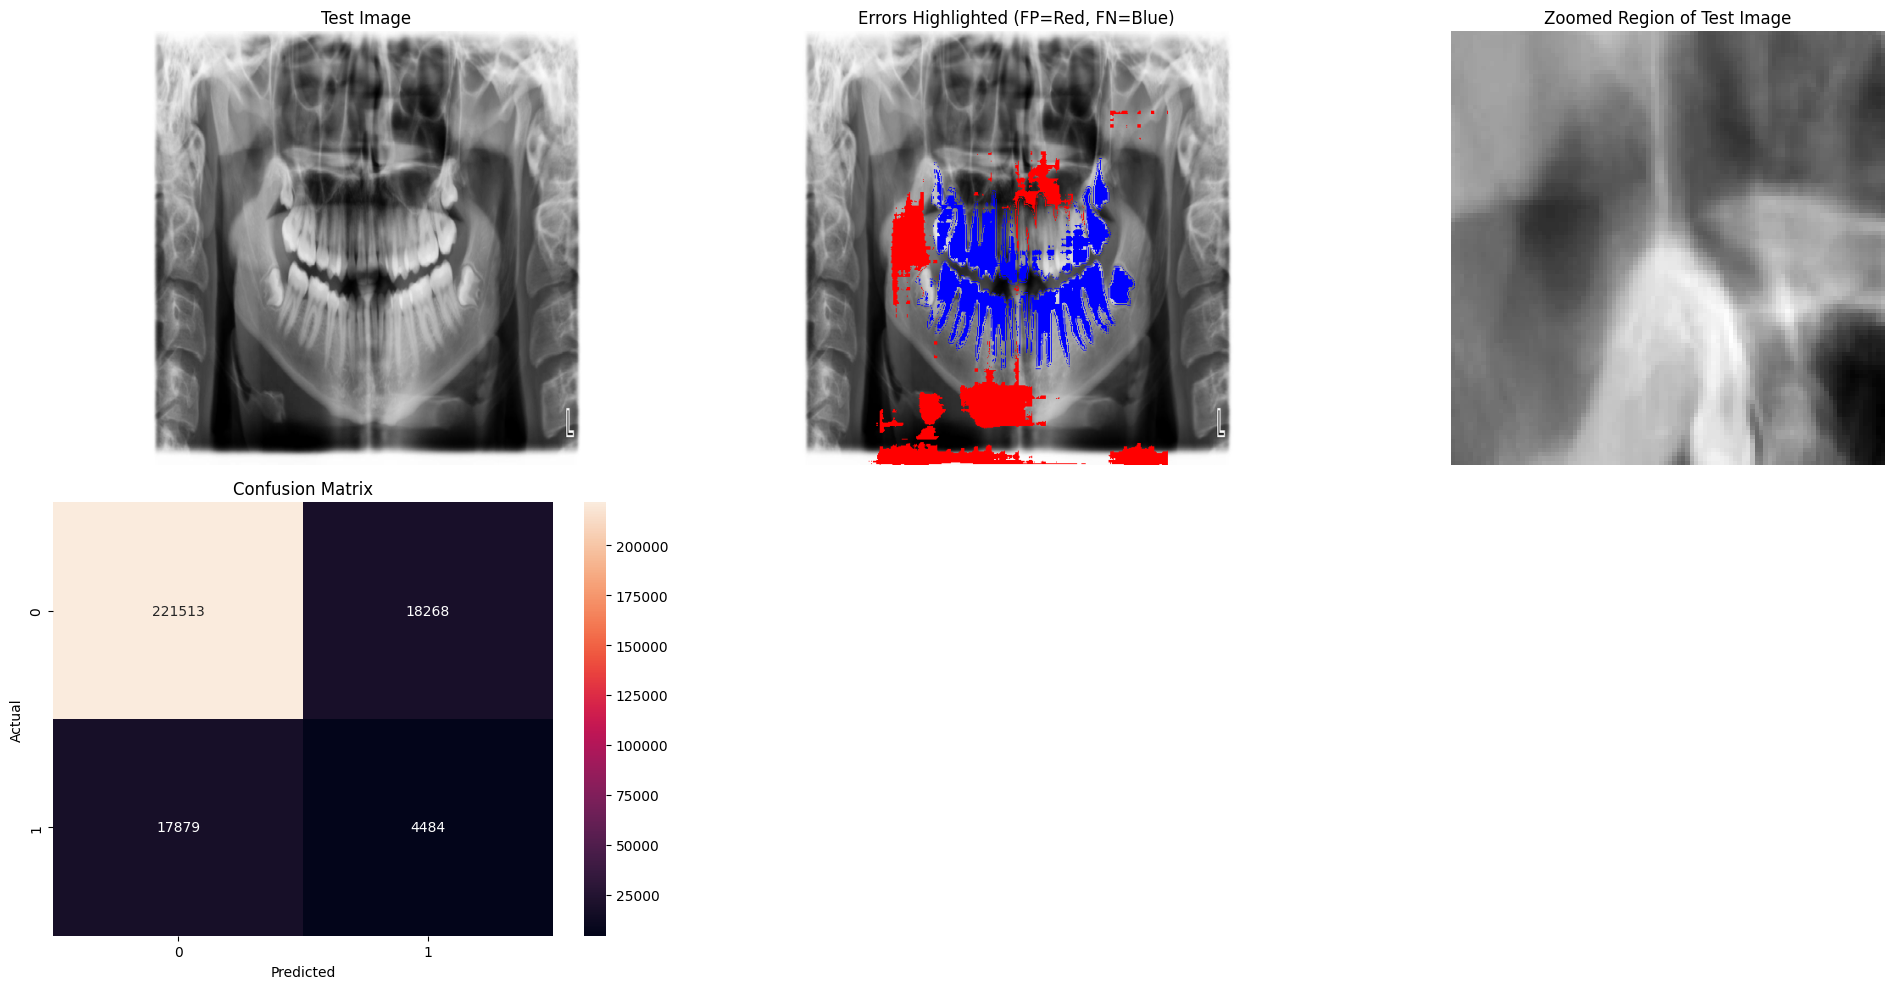

In [27]:
advanced_visualization(x_test[1,:,:,0], y_test[1,:,:,0], predict)

## **Run below Code after Training or Loading each of the above Models**

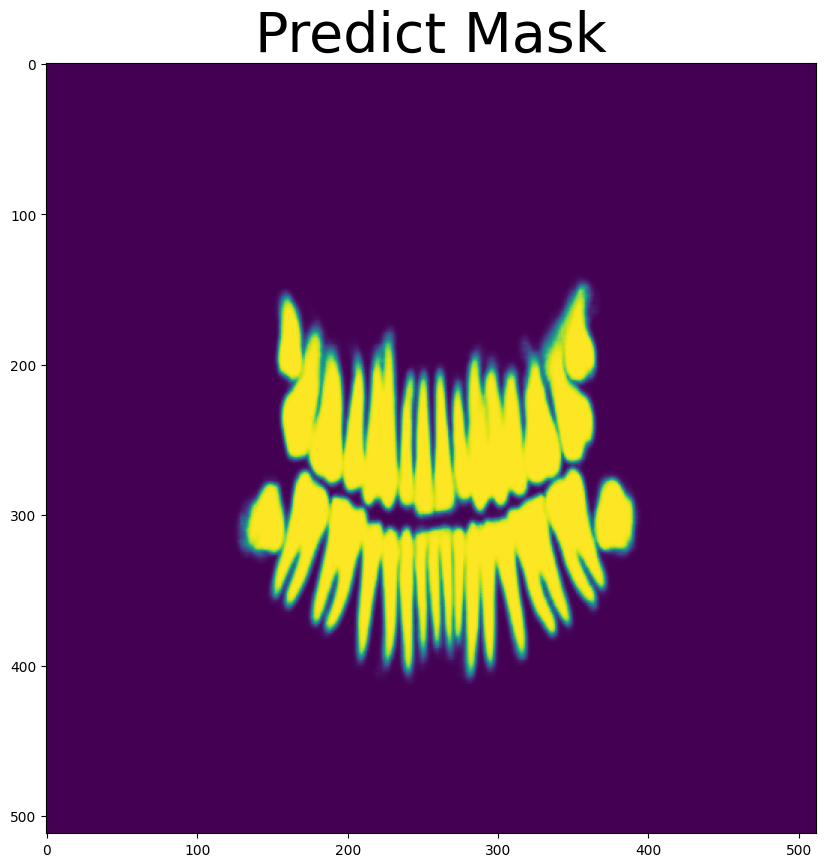

In [35]:
plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(predict)
plt.imsave("/content/drive/MyDrive/dissertation/Resutls_Images/predict_512x512.png",predict)

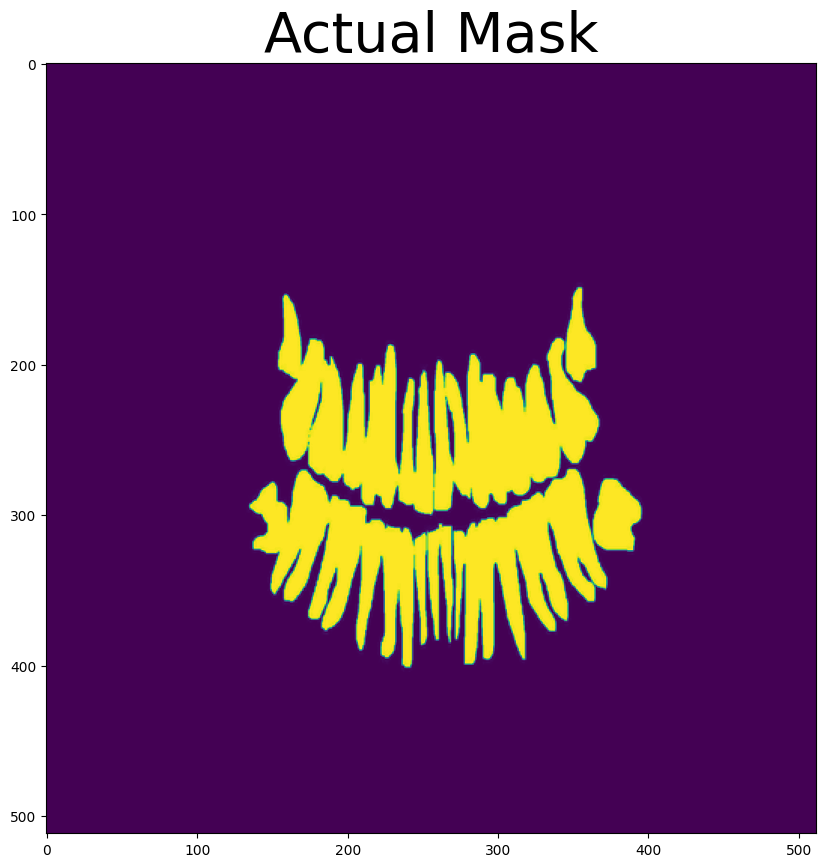

In [36]:
ground_truth = y_test[1,:,:,0]
plt.figure(figsize = (20,10))
plt.title("Actual Mask",fontsize = 40)
plt.imshow(ground_truth)
plt.imsave("/content/drive/MyDrive/dissertation/Resutls_Images/actual__512x512.png",ground_truth)

## **Drawing Contours**

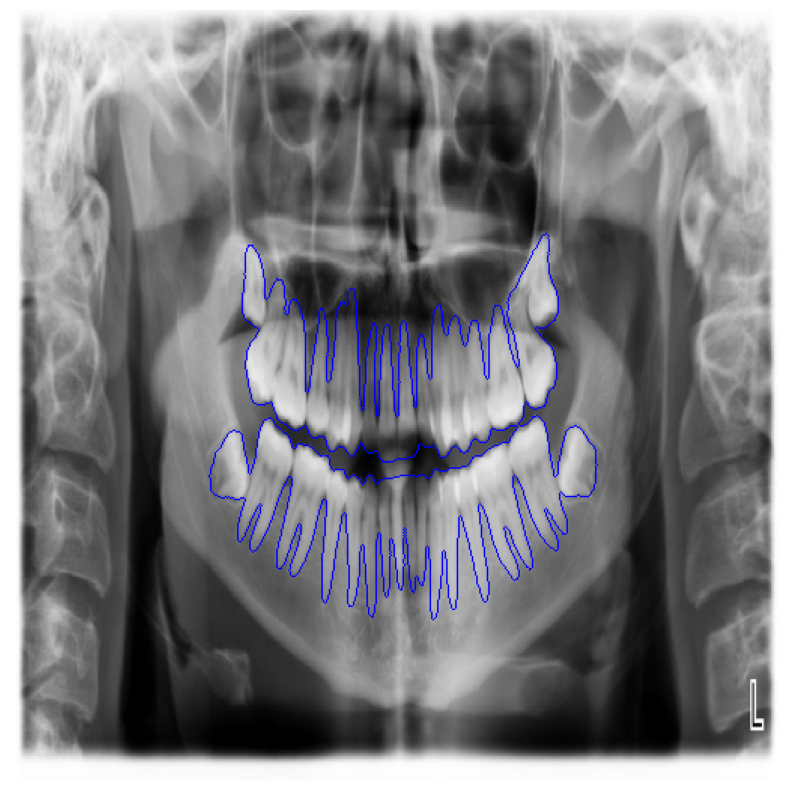

In [37]:
import cv2
import matplotlib.pyplot as plt
from CCA_Analysis import *

# Load the original image that you use for prediction
img = x_test[1]

# Convert the format and values if necessary
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # convert to BGR if necessary
img = np.uint8(img * 255)  # convert to 0-255 if necessary

#Saving in the drive for future use
plt.imsave('/content/drive/MyDrive/dissertation/Resutls_Images/image_test_512x512.png', img, cmap='gray')

# Resize the prediction to match the original image size
predict1 = cv2.resize(predict, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# Convert prediction to a binary mask
mask = np.uint8(predict1 * 255)
_, mask = cv2.threshold(mask, thresh=255/2, maxval=255, type=cv2.THRESH_BINARY)

# Find contours in the mask
cnts, hieararch = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw contours on
img_with_contours = img.copy()

# Draw contours on the copied image
img_with_contours = cv2.drawContours(img_with_contours, cnts, -1, (255, 0, 0), 1)

# Display the modified image with contours using matplotlib
plt.figure(figsize=(10, 10))  # Set the figure size here
plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.axis('off')
plt.show()

## **Applying WaterShed Method for Counting of Teeths**

Teeth Count: 20


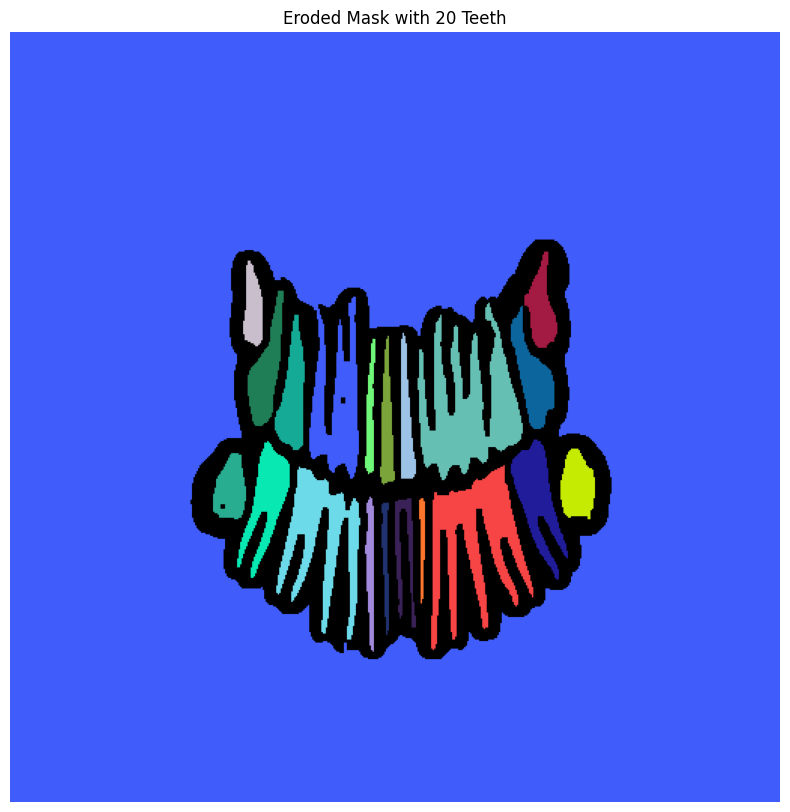

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def adaptive_threshold_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

def erode_mask(mask, kernel_size=3, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.erode(mask, kernel, iterations=iterations)

def count_objects_in_mask(mask):
    _, output = cv2.connectedComponents(mask)
    return output.max()  # Returns the number of unique components (minus 1 for the background)

def remove_thin_lines(mask, kernel_size, iterations=2):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_size))

    cleaned_mask = np.copy(mask)
    for i in range(iterations):
        # Erode with the kernel
        lines = cv2.erode(cleaned_mask, kernel, iterations=1)
        lines = cv2.dilate(lines, kernel, iterations=1)

        # Subtract the eroded mask from the original mask to highlight the lines
        highlighted_lines = cv2.subtract(cleaned_mask, lines)

        # Remove the highlighted lines from the mask
        cleaned_mask = cv2.subtract(cleaned_mask, highlighted_lines)

    return cleaned_mask

def color_components(mask):
    # Get connected components
    num_labels, labels = cv2.connectedComponents(mask)

    # Map each label to a random RGB color
    colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=int)
    colors[0] = [0, 0, 0]  # Set background color to black

    # Create a color image
    color_img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(1, num_labels):  # Skip the background
        color_img[labels == i] = colors[i]

    return color_img

# Load the predicted mask
predicted = cv2.imread("/content/drive/MyDrive/dissertation/Resutls_Images/predict_512x512.png")
enhanced_mask = adaptive_threshold_mask(predicted)

# Erode the mask to create more separation
eroded_mask = erode_mask(enhanced_mask, kernel_size=3, iterations=1)

cleaned_mask = remove_thin_lines(eroded_mask, kernel_size=5, iterations=2)

# Counting teeth in the cleaned mask
teeth_count = count_objects_in_mask(cleaned_mask)
print(f"Teeth Count: {teeth_count}")

# Color each tooth
colored_image = color_components(cleaned_mask)

plt.figure(figsize=(10, 10))
plt.imshow(colored_image)
plt.axis('off')
plt.title(f'Eroded Mask with {teeth_count} Teeth')
plt.show()